# River/Municipality Adjacency

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import sys
sys.path.append("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/code")
from data.preprocess.river_network import calculate_distance_from_estuary

In [144]:
rivers_brazil_shapefile = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/river_network/shapefile.feather")
rivers_brazil_topology = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/river_network/topology.feather")

rivers_brazil_shapefile = calculate_distance_from_estuary(rivers_brazil_shapefile, rivers_brazil_topology)

municipalities_brazil_shapefile = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/raw/gadm/gadm41_BRA_2.json", engine="pyogrio")

In [145]:
joined = rivers_brazil_shapefile.sjoin(municipalities_brazil_shapefile.to_crs(5641), how="inner")

In [112]:
import json
with open("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/river_network/reachability.json", "r") as f:
    reachability = json.load(f)

In [171]:
nodes_municipalities = joined.groupby("GID_2").upstream_node_id.unique()

In [174]:
reachability_municipalities = nodes_municipalities.apply(lambda x: list(set(chain(*[reachability.get(str(y), []) for y in x]))))

In [178]:
reachability_municipalities.apply(len).idxmax()

'BRA.3.7_2'

In [184]:
brazil_total = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/raw/gadm/gadm41_BRA_0.json", engine="pyogrio")

<Axes: >

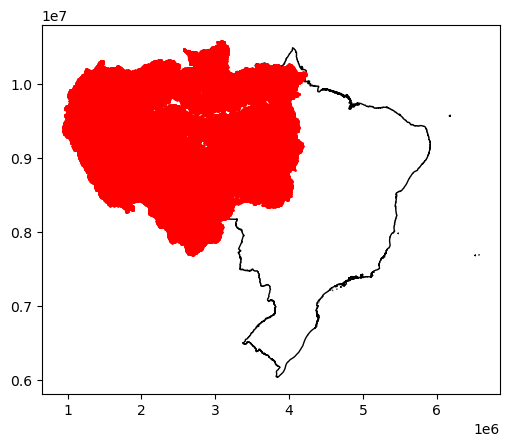

In [185]:
from itertools import chain
ax = municipalities_brazil_shapefile.query(f"GID_2=='BRA.3.7_2'").to_crs(5641).plot(markersize = 10)
brazil_total.to_crs(5641).plot(ax=ax, color="none", edgecolor="black")
rivers_brazil_topology.loc[reachability_municipalities['BRA.3.7_2']].plot(ax=ax, markersize=1, color="red")


---

# Polygon Extraction

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/code")
from data.preprocess.drainage_polygons.aux_functions import expand_bounds, load_height_profile

In [2]:
# connect to database
conn = sqlite3.connect('/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/imagery/imagery.db')
# get grid data
grid_data = pd.read_sql_query("SELECT * FROM GridCells WHERE Internal=1", conn)
# get grid geometries
grid_geoms = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/imagery/grid_cells.feather")
# merge data
grid_data = gpd.GeoDataFrame(grid_data.merge(grid_geoms, on = "CellID"))
# close connection
conn.close()

In [35]:
rivers_brazil_shapefile = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/river_network/shapefile.feather")
drainage_polygons = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/code/experiments/test.feather")
drainage_polygons_dissolved = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage/drainage_polygons_dissolved_filtered.feather").reset_index(drop=True)

In [36]:
import shapely
# Identify large polygons
drainage_polygons_dissolved["too_large"] = gpd.GeoSeries(drainage_polygons_dissolved.bounds.apply(lambda x: shapely.box(*x), axis=1)).area > 1

In [39]:
gpd.GeoSeries(drainage_polygons_dissolved.bounds.apply(lambda x: shapely.box(*x), axis=1)).area.idxmax()

77737

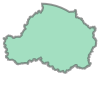

In [40]:
drainage_polygons_dissolved.loc[77737].geometry

In [29]:
drainage_polygons_dissolved["too_large"].sum()

5

In [5]:
to_fix = drainage_polygons_dissolved[drainage_polygons_dissolved.too_large].copy()
drainage_polygons_dissolved = drainage_polygons_dissolved[~drainage_polygons_dissolved.too_large]
drainage_polygons_dissolved.drop(columns="too_large", inplace=True)

In [6]:
to_append = []
for c_estuary, c_river in zip(to_fix.estuary, to_fix.river):
    t_query_polygons = drainage_polygons.query(f"estuary == {c_estuary} and river == {c_river}").to_crs(5641)
    t_query_river = rivers_brazil_shapefile.query(f"estuary == {c_estuary} and river == {c_river}").sort_values("segment").dissolve()

    t_query_polygons["distance_along_river"] = t_query_polygons.centroid.apply(lambda x: t_query_river.project(x))
    t_query_polygons[["cumulative_bbox", "dissolve_group"]] = None
    t_query_polygons = t_query_polygons.sort_values("distance_along_river")
    t_query_polygons = t_query_polygons.to_crs(4326)

    t_group = 0
    t_query_polygons["cumulative_bbox"] = t_query_polygons.bounds.apply(lambda x: shapely.box(*x), axis = 1)
    t_query_polygons.loc[:,"dissolve_group"].iloc[0] = t_group

    for i in range(1, len(t_query_polygons)):
        t_bbox = shapely.box(*t_query_polygons.cumulative_bbox.iloc[i-1].union(t_query_polygons.cumulative_bbox.iloc[i]).bounds)
        if t_bbox.area < 1:
            t_query_polygons.iloc[i, t_query_polygons.columns.get_loc("cumulative_bbox")] = t_bbox
            t_query_polygons.iloc[i, t_query_polygons.columns.get_loc("dissolve_group")] = t_group
        else:
            t_group += 1
            t_query_polygons.iloc[i, t_query_polygons.columns.get_loc("dissolve_group")] = t_group
    t_query_polygons["geometry"] = t_query_polygons.buffer(0)
    t_query_polygons = t_query_polygons.dissolve("dissolve_group")
    to_append.append(t_query_polygons.loc[:,["estuary", "river", "geometry"]].reset_index(drop=True))

In [ ]:
[to_append]

In [22]:
pd.concat(to_append, keys=range(len(to_append))).bounds.apply(lambda x: shapely.box(*x).area, axis=1).idxmax()

(354, 0)

In [8]:
grid_data.iloc[gpd.sjoin(pd.concat(to_append).to_crs(5641), grid_data).index_right.unique()]

,CellID,Row,Column,X,Y,Internal,geometry
144,385,7,28,4347855.0,9783945.0,1,"POLYGON ((4447665.000 9883755.000, 4447665.000..."
143,384,7,27,4248015.0,9783945.0,1,"POLYGON ((4347825.000 9883755.000, 4347825.000..."
116,334,6,28,4347855.0,9883785.0,1,"POLYGON ((4447665.000 9983595.000, 4447665.000..."
170,433,8,25,4048335.0,9684105.0,1,"POLYGON ((4148145.000 9783915.000, 4148145.000..."
141,382,7,25,4048335.0,9783945.0,1,"POLYGON ((4148145.000 9883755.000, 4148145.000..."
...,...,...,...,...,...,...,...
598,959,18,41,5645775.0,8685705.0,1,"POLYGON ((5745585.000 8785515.000, 5745585.000..."
516,854,16,38,5346255.0,8885385.0,1,"POLYGON ((5446065.000 8985195.000, 5446065.000..."
21,123,2,21,3648975.0,10283145.0,1,"POLYGON ((3748785.000 10382955.000, 3748785.00..."
20,122,2,20,3549135.0,10283145.0,1,"POLYGON ((3648945.000 10382955.000, 3648945.00..."


In [104]:
pd.concat([drainage_polygons_dissolved] + to_append)

,estuary,river,geometry
0,0.0,0.0,"POLYGON ((-51.38523 -30.56514, -51.38649 -30.5..."
1,0.0,1.0,"POLYGON ((-51.31802 -30.48339, -51.31876 -30.4..."
2,1.0,0.0,"POLYGON ((-52.25156 -32.14379, -52.25116 -32.1..."
3,2.0,0.0,"POLYGON ((-53.46594 -33.68885, -53.46709 -33.6..."
4,2.0,2.0,"POLYGON ((-53.25544 -33.42960, -53.25542 -33.4..."
...,...,...,...
0,534.0,0.0,"POLYGON ((-54.04531 5.63461, -54.04531 5.62849..."
0,830.0,47.0,"MULTIPOLYGON (((-45.66893 -3.13436, -45.66926 ..."
1,830.0,47.0,"MULTIPOLYGON (((-46.50190 -3.46410, -46.50294 ..."
0,866.0,0.0,"MULTIPOLYGON (((-46.03975 -2.47768, -46.04025 ..."


In [90]:
drainage_polygons_dissolved

,estuary,river,geometry,too_large
0,0.0,0.0,"POLYGON ((-51.38523 -30.56514, -51.38649 -30.5...",False
1,0.0,1.0,"POLYGON ((-51.31802 -30.48339, -51.31876 -30.4...",False
2,1.0,0.0,"POLYGON ((-52.25156 -32.14379, -52.25116 -32.1...",False
3,2.0,0.0,"POLYGON ((-53.46594 -33.68885, -53.46709 -33.6...",False
4,2.0,2.0,"POLYGON ((-53.25544 -33.42960, -53.25542 -33.4...",False
...,...,...,...,...
85863,1010.0,0.0,"POLYGON ((-52.26203 4.59461, -52.26356 4.59652...",False
85864,1013.0,0.0,"POLYGON ((-51.94615 4.52262, -51.94656 4.52174...",False
85865,1014.0,0.0,"POLYGON ((-52.24516 4.74144, -52.24536 4.74238...",False
85866,1015.0,0.0,"POLYGON ((-52.42597 4.81324, -52.42517 4.81461...",False


In [24]:
test_drainage_polygons = to_append[354].iloc[[0]]

In [22]:
import os
files = os.listdir("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage/temp_extracted_grid_cells")
files = pd.Series(files).str.extract(r"(\d*)").squeeze().astype(int).unique()
np.array([file for file in grid_data.index if file not in files and drainage_polygons.centroid.intersects(grid_data.iloc[[file]].to_crs(4326).iloc[0].geometry).any()])

array([133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 355, 356, 357,
       358, 359, 360, 361, 362, 363, 375, 376, 655, 656, 657, 658, 659,
       660, 661, 662, 901, 902, 903, 904, 905, 906, 907, 908, 909])

In [13]:
import shapely
gpd.GeoSeries(drainage_polygons.bounds.apply(lambda x: shapely.box(*x), axis=1)).area.quantile(0.99)

0.3997133040244743

In [38]:
test_drainage_polygons = drainage_polygons.loc[drainage_polygons.centroid.intersects(grid_data.iloc[[525]].to_crs(4326).iloc[0].geometry)]

In [25]:
import tempfile
from pysheds.grid import Grid
import shapely

# Load the DEM into a pysheds raster via rioxarray and a temporary file
with tempfile.NamedTemporaryFile() as memfile:
    # Load and preprocess height profile within the bounding box of the sub-polygon, expanded by 1.2 units
    t_height_profile = load_height_profile(expand_bounds(test_drainage_polygons.total_bounds, 1.2))
    # Fill missing values, set no data value, and save as raster
    t_height_profile.fillna(t_height_profile.max()).rio.write_nodata(-32767).rio.to_raster(memfile.name, driver="GTiff")
    # Load this raster into a pysheds grid
    c_grid = Grid.from_raster(memfile.name)
    c_dem = c_grid.read_raster(memfile.name)

# Hydrological processing to refine the DEM for accurate flow direction and accumulation computation
t_pit_filled_dem = c_grid.fill_pits(c_dem)  # Fill pits
t_flooded_dem = c_grid.fill_depressions(t_pit_filled_dem)  # Fill depressions
t_inflated_dem = c_grid.resolve_flats(t_flooded_dem)  # Resolve flat areas
t_fdir = c_grid.flowdir(t_inflated_dem, dirmap=(64, 128, 1, 2, 4, 8, 16, 32))  # Compute flow direction
c_acc = c_grid.accumulation(t_fdir, dirmap=(64, 128, 1, 2, 4, 8, 16, 32)) 

t_extracted_river_network = c_grid.extract_river_network(t_fdir, c_acc > 500, dirmap=(64, 128, 1, 2, 4, 8, 16, 32))["features"]

In [81]:
result_total = gpd.GeoDataFrame(t_extracted_river_network, crs=4326)

<Axes: >

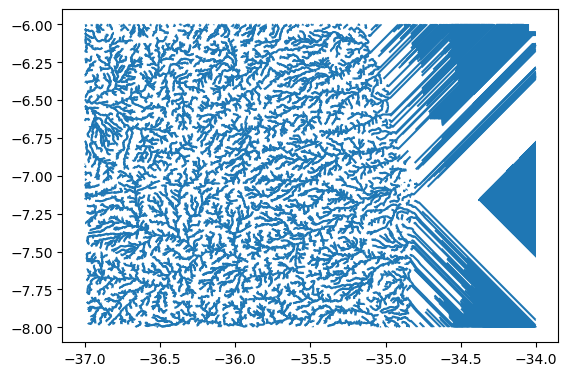

In [82]:
result_total.plot()

In [52]:
(expand_bounds(test_drainage_polygons.total_bounds, 1.2)[2] - expand_bounds(test_drainage_polygons.total_bounds, 1.2)[0]) / 19200

0.0007587523937499974

In [54]:
0.001 * 10000

10.0

In [53]:
(expand_bounds(test_drainage_polygons.total_bounds, 1.2)[3] - expand_bounds(test_drainage_polygons.total_bounds, 1.2)[1]) / 13200

0.0007168992249566268

In [48]:
test_drainage_polygons = drainage_polygons.loc[drainage_polygons.centroid.intersects(grid_data.iloc[[901]].to_crs(4326).iloc[0].geometry)]
load_height_profile(expand_bounds(test_drainage_polygons.total_bounds, 1.2))

<xarray.DataArray (y: 13200, x: 19200)> Size: 1GB
array([[200.33273 , 200.45097 , 201.22864 , ..., 545.9667  , 540.37225 ,
        551.1611  ],
       [200.24927 , 201.23233 , 200.14708 , ..., 563.41144 , 558.353   ,
        562.5517  ],
       [201.61275 , 201.72462 , 198.7732  , ..., 573.2265  , 583.59576 ,
        591.5671  ],
       ...,
       [ 92.31181 ,  93.18843 ,  94.10228 , ...,        nan,        nan,
               nan],
       [ 93.05983 ,  93.82538 ,  94.534615, ...,        nan,        nan,
               nan],
       [ 93.32597 ,  94.03605 ,  94.78736 , ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
  * x            (x) float64 154kB -58.0 -58.0 -58.0 -58.0 ... -42.0 -42.0 -42.0
  * y            (y) float64 106kB -18.0 -18.0 -18.0 -18.0 ... -29.0 -29.0 -29.0
    band         int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Point
    scale_factor:   1.0
    add_offset:     0.0
    units:          metre

In [87]:
buffered_union = test_drainage_polygons.buffer(0.1).unary_union

In [90]:
def split_bounding_box(bbox, max_width=3, max_height=3):
    # Unpack the bounding box coordinates
    xmin, ymin, xmax, ymax = bbox
    
    # Calculate the number of divisions on the x and y axes
    num_x = np.ceil((xmax - xmin) / max_width).astype(int)
    num_y = np.ceil((ymax - ymin) / max_height).astype(int)
    
    # Generate the sub-box coordinates
    sub_boxes = []
    for i in range(num_x):
        for j in range(num_y):
            sub_xmin = xmin + i * max_width
            sub_ymin = ymin + j * max_height
            sub_xmax = min(sub_xmin + max_width, xmax)
            sub_ymax = min(sub_ymin + max_height, ymax)
            sub_boxes.append([sub_xmin, sub_ymin, sub_xmax, sub_ymax])
    
    return np.array(sub_boxes)

split_boxes = split_bounding_box(expand_bounds(test_drainage_polygons.total_bounds, 1.2))
split_boxes = [x for x in split_boxes if buffered_union.intersects(shapely.box(*x))]

In [109]:
from itertools import product

def load_height_profile(bbox, polygon = None, dem_path = "/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/raw/DEM_GLO-90/"):
    """
    Load and return the height profile for a given bounding box.

    Args:
    bbox (tuple): A tuple representing the bounding box with four values (min latitude, min longitude, max latitude, max longitude).

    Returns:
    xarray.DataArray: An array containing the height profile within the specified bounding box.
    """

    # Generate file path suffixes for latitude and longitude using grid conventions
    # Latitudes and longitudes are formatted based on their hemisphere and rounded to the nearest degree
    lat_lon = list(product(
        [lat for lat in np.arange(np.floor(bbox[0]), np.ceil(bbox[2]), 1)],
        [lon for lon in np.arange(np.floor(bbox[1]), np.ceil(bbox[3]), 1)]
    ))
    
    # Filter out files that do not intersect the polygon
    if polygon is not None:
        lat_lon = filter(lambda x: shapely.box(x[0], x[1], x[0] + 1, x[1] + 1).intersects(polygon), lat_lon)
    
    lat_lon = [
        (f"E{int(lat):03}" if lat >= 0 else f"W{-int(lat):03}", 
         f"N{int(lon):02}" if lon >= 0 else f"S{-int(lon):02}") for lat, lon in lat_lon
    ]
    
    # Construct file paths for DEM (Digital Elevation Model) tiles within the bounding box
    files_dem_cop = [
        f"{dem_path}Copernicus_DSM_30_{lon}_00_{lat}_00/DEM/Copernicus_DSM_30_{lon}_00_{lat}_00_DEM.tif"
        for lat, lon in lat_lon
    ]
    
    # Filter out files that do not exist
    files_dem_cop = [file for file in files_dem_cop if os.path.exists(file)]

    # Load the DEM files and combine them into a single DataArray using xarray, keeping the first channel and excluding the last pixel on each edge
    height_profile = xr.combine_by_coords([
        rxr.open_rasterio(file)[0, :-1, :-1] for file in files_dem_cop
    ])

    # # Clip the combined height profile to exactly match the bounding box using rioxarray
    # height_profile = height_profile.rio.clip_box(*bbox)

    return height_profile

In [113]:
with tempfile.NamedTemporaryFile() as memfile:
    # Load and preprocess height profile within the bounding box of the sub-polygon, expanded by 1.2 units
    t_height_profile = load_height_profile(expand_bounds(test_drainage_polygons.total_bounds, 1.2), buffered_union)
    # Fill missing values, set no data value, and save as raster
    t_height_profile.fillna(t_height_profile.max()).rio.write_nodata(-32767).rio.to_raster(memfile.name, driver="GTiff")
    # Load this raster into a pysheds grid
    c_grid = Grid.from_raster(memfile.name)
    c_dem = c_grid.read_raster(memfile.name)

# Hydrological processing to refine the DEM for accurate flow direction and accumulation computation
t_pit_filled_dem = c_grid.fill_pits(c_dem)  # Fill pits
t_flooded_dem = c_grid.fill_depressions(t_pit_filled_dem)  # Fill depressions
t_inflated_dem = c_grid.resolve_flats(t_flooded_dem)  # Resolve flat areas
t_fdir = c_grid.flowdir(t_inflated_dem, dirmap=(64, 128, 1, 2, 4, 8, 16, 32))  # Compute flow direction
c_acc = c_grid.accumulation(t_fdir, dirmap=(64, 128, 1, 2, 4, 8, 16, 32)) 

checkpoint


: 

: 

In [93]:
from tqdm import tqdm

out = [None] * len(split_boxes)
for i in tqdm(range(len(split_boxes))):
    # Load the DEM into a pysheds raster via rioxarray and a temporary file
    with tempfile.NamedTemporaryFile() as memfile:
        # Load and preprocess height profile within the bounding box of the sub-polygon, expanded by 1.2 units
        t_height_profile = load_height_profile(expand_bounds(split_boxes[i], 1.2))
        # Fill missing values, set no data value, and save as raster
        t_height_profile.fillna(t_height_profile.max()).rio.write_nodata(-32767).rio.to_raster(memfile.name, driver="GTiff")
        # Load this raster into a pysheds grid
        c_grid = Grid.from_raster(memfile.name)
        c_dem = c_grid.read_raster(memfile.name)

    # Hydrological processing to refine the DEM for accurate flow direction and accumulation computation
    t_pit_filled_dem = c_grid.fill_pits(c_dem)  # Fill pits
    t_flooded_dem = c_grid.fill_depressions(t_pit_filled_dem)  # Fill depressions
    t_inflated_dem = c_grid.resolve_flats(t_flooded_dem)  # Resolve flat areas
    t_fdir = c_grid.flowdir(t_inflated_dem, dirmap=(64, 128, 1, 2, 4, 8, 16, 32))  # Compute flow direction
    c_acc = c_grid.accumulation(t_fdir, dirmap=(64, 128, 1, 2, 4, 8, 16, 32)) 

    t_extracted_river_network = c_grid.extract_river_network(t_fdir, c_acc > 500, dirmap=(64, 128, 1, 2, 4, 8, 16, 32))["features"]
    out[i] = gpd.GeoDataFrame(t_extracted_river_network, crs=4326)

100%|██████████| 10/10 [05:14<00:00, 31.42s/it]


In [100]:
out_clipped = [gpd.clip(out[i], shapely.box(*split_boxes[i])) for i in range(len(split_boxes))]

In [102]:
pd.concat(out_clipped)

,type,id,geometry,properties
22608,Feature,22608,"LINESTRING (-55.58864 -28.36386, -55.58875 -28...",{}
23498,Feature,23498,"LINESTRING (-55.55458 -28.36386, -55.55458 -28...",{}
22480,Feature,22480,"LINESTRING (-55.52792 -28.36042, -55.52875 -28...",{}
23501,Feature,23501,"LINESTRING (-55.58375 -28.33708, -55.58458 -28...",{}
22560,Feature,22560,"LINESTRING (-55.50875 -28.33792, -55.50792 -28...",{}
...,...,...,...,...
2191,Feature,2191,"LINESTRING (-43.53708 -19.43042, -43.53708 -19...",{}
2603,Feature,2603,"LINESTRING (-43.54875 -19.44375, -43.54875 -19...",{}
1946,Feature,1946,"LINESTRING (-43.55125 -19.38792, -43.55208 -19...",{}
1974,Feature,1974,"LINESTRING (-43.52042 -19.39292, -43.52125 -19...",{}


In [104]:
pd.concat(out_clipped).dissolve().explode()

type     id properties  \
0 0       Feature  22608         {}   
  1       Feature  22608         {}   
  2       Feature  22608         {}   
  3       Feature  22608         {}   
  4       Feature  22608         {}   
...           ...    ...        ...   
  133102  Feature  22608         {}   
  133103  Feature  22608         {}   
  133104  Feature  22608         {}   
  133105  Feature  22608         {}   
  133106  Feature  22608         {}   

                                                   geometry  
0 0       LINESTRING (-55.58864 -28.36386, -55.58875 -28...  
  1       LINESTRING (-55.55458 -28.36386, -55.55458 -28...  
  2       LINESTRING (-55.52792 -28.36042, -55.52875 -28...  
  3       LINESTRING (-55.58375 -28.33708, -55.58458 -28...  
  4       LINESTRING (-55.50875 -28.33792, -55.50792 -28...  
...                                                     ...  
  133102  LINESTRING (-43.53708 -19.43042, -43.53708 -19...  
  133103  LINESTRING (-43.54875 -19.44375, -43.54875 -19...  
  133104  LINESTRING (-43.55125 -19.38792, -43.55208 -19...  
  133105  LINESTRING (-43.52042 -19.39292, -43.52125 -19...  
  133106  LINESTRING (-43.49542 -19.39125, -43.49625 -19...  

[133107 rows x 4 columns]

<Axes: >

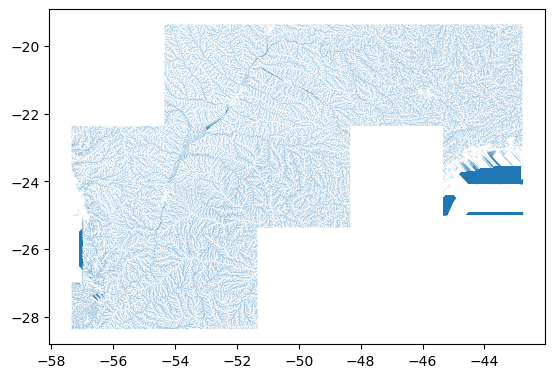

In [101]:
pd.concat(out_clipped).plot(linewidths = .1)

In [77]:
legend = pd.read_excel("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/legend/mapbiomas_legend.xlsx")

In [107]:
class_labels = {
    "forest": legend.loc[legend.Class.str.match(r"(^1\.)"), "ID"].values,
    "non-forest/natural": legend.loc[legend.Class.str.match(r"(^2\.)"), "ID"].values,
    "farming": legend.loc[legend.Class.str.match(r"(^3\.)"), "ID"].values,
    "pasture": legend.loc[legend.Class.str.match(r"(^3\.1)"), "ID"].values,
    "agriculture": legend.loc[legend.Class.str.match(r"(^3\.2)"), "ID"].values,
    "non-vegetated": legend.loc[legend.Class.str.match(r"(^4\.)"), "ID"].values,
    "urban": legend.loc[legend.Class.str.match(r"(^4\.2)"), "ID"].values,
    "mining": legend.loc[legend.Class.str.match(r"(^4\.3)"), "ID"].values,
    "water": legend.loc[legend.Class.str.match(r"(^5\.)"), "ID"].values,
    }

In [128]:
baseline = rxr.open_rasterio("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/raw/lc_mapbiomas8_30/mapbiomas_brasil_coverage_1990.tif", chunks=True).squeeze()#.expand_dims(dim={"year": 1}).assign_coords(year=[1990])
compare = rxr.open_rasterio("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/raw/lc_mapbiomas8_30/mapbiomas_brasil_coverage_2022.tif", chunks=True).squeeze()#.expand_dims(dim={"year": 1}).assign_coords(year=[2019])

In [ ]:
# two approaches:
# 1. sum of area
# 2. count deforestation events

In [188]:
import pickle


In [176]:
polygons = gpd.clip(drainage_polygons, grid_data.iloc[[525]].to_crs(4326).total_bounds)
year = 1991

In [199]:
# load land cover data
lc_t = rxr.open_rasterio(f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/raw/lc_mapbiomas8_30/mapbiomas_brasil_coverage_{year}.tif", chunks=True).squeeze()
lc_t_1 = rxr.open_rasterio(f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/raw/lc_mapbiomas8_30/mapbiomas_brasil_coverage_{year-1}.tif", chunks=True).squeeze()

In [252]:
# get extracted drainage polygons
polygons = pd.concat(pickle.load(open("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage/temp_extracted_grid_cells/254.pkl", "rb"))).reset_index(drop=True)

# clip land cover data
lc_t_subset = lc_t.rio.clip_box(*expand_bounds(polygons.total_bounds))
lc_t_1_subset = lc_t_1.rio.clip_box(*expand_bounds(polygons.total_bounds))

In [266]:
# extract land cover information
t_out_list = {}
for idx in polygons.index:
    # get polygon
    c_polygon = polygons.iloc[idx].geometry
    # check if polygon is empty or irregularly small
    if c_polygon is None:
        continue
    elif c_polygon.is_empty or c_polygon.area < 1e-15:
        continue
    # clip to polygon
    t_lc_t_clip = lc_t_subset.rio.clip_box(*expand_bounds(c_polygon.bounds)).rio.clip([c_polygon])
    t_lc_t_1_clip = lc_t_1_subset.rio.clip_box(*expand_bounds(c_polygon.bounds)).rio.clip([c_polygon])
    # get unique counts
    t_counts = np.unique(t_lc_t_clip, return_counts=True)
    t_counts = pd.Series(t_counts[1], index=t_counts[0])
    
    t_events = pd.Series(
        [
            (t_lc_t_1_clip.isin(class_labels["forest"]) & ~ t_lc_t_clip.isin(class_labels["forest"])).sum().values,
            (t_lc_t_1_clip.isin(class_labels["forest"]) & t_lc_t_clip.isin(class_labels["pasture"])).sum().values,
            (t_lc_t_1_clip.isin(class_labels["forest"]) & t_lc_t_clip.isin(class_labels["agriculture"])).sum().values,
            (t_lc_t_1_clip.isin(class_labels["forest"]) & t_lc_t_clip.isin(class_labels["urban"])).sum().values,
            (t_lc_t_1_clip.isin(class_labels["forest"]) & t_lc_t_clip.isin(class_labels["mining"])).sum().values
        ],
        index=["deforestation", "to_pasture", "to_agriculture", "to_urban", "to_mining"]
    )
    
    # get deforestation events
    t_out_list |= {idx: pd.concat([t_counts, t_events]).to_dict()}

In [228]:
c_sums = pd.DataFrame.from_dict(t_counts_list, orient="index")
c_sums = polygons.join(c_sums)

In [242]:
# Compute the sum of each set of columns
sums = {}
for name, columns in class_labels.items():
    present_columns = [col for col in columns if col in c_sums.columns]
    if present_columns:
        sums[name] = c_sums[present_columns].sum(axis=1)
# Convert the sums dictionary to a DataFrame if needed
sums_df = pd.DataFrame(sums)

In [249]:
means_df = pd.Series(sums_df.forest / sums_df.sum(axis=1), name="forest_share")

<Axes: >

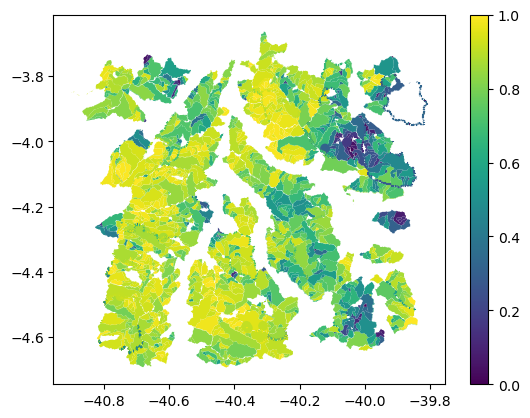

In [251]:
polygons.join(means_df).plot(column="forest_share", legend=True)

In [172]:
pd.DataFrame(t_counts_series).T

,0,3
0,102218,124


In [157]:
pd.Series(zip(*np.unique(lc_t.rio.clip_box(*c_polygon.bounds).rio.clip([c_polygon]), return_counts=True)))

0    (0, 102218)
1       (3, 124)
dtype: object

In [110]:
compare_pasture = compare.rio.clip_box(*grid_data.iloc[[525]].to_crs(4326).total_bounds).isin(class_labels["pasture"]) * 2
compare_agriculture = compare.rio.clip_box(*grid_data.iloc[[525]].to_crs(4326).total_bounds).isin(class_labels["agriculture"]) * 3
compare_urban = compare.rio.clip_box(*grid_data.iloc[[525]].to_crs(4326).total_bounds).isin(class_labels["urban"]) * 4
compare_mining = compare.rio.clip_box(*grid_data.iloc[[525]].to_crs(4326).total_bounds).isin(class_labels["mining"]) * 5

In [116]:
(baseline_forest * compare_pasture).any().values

array(True)

In [124]:
(baseline_forest * compare_agriculture).sum().values

array(447)

In [125]:
from matplotlib.colors import ListedColormap

# Your dictionary of ranges and RGB values
custom_colors = {
    (0, 1): "#FFFFFF",
    (1, 2): "#edde8e",
    (2, 3): "#E974ED",
    (3, 4): "#d4271e",
    (4, 5): "#9c0027",
}

# Creating the custom colormap
colors = []
for key in sorted(custom_colors.keys()):
    colors.append(custom_colors[key])
cmap = ListedColormap(colors)

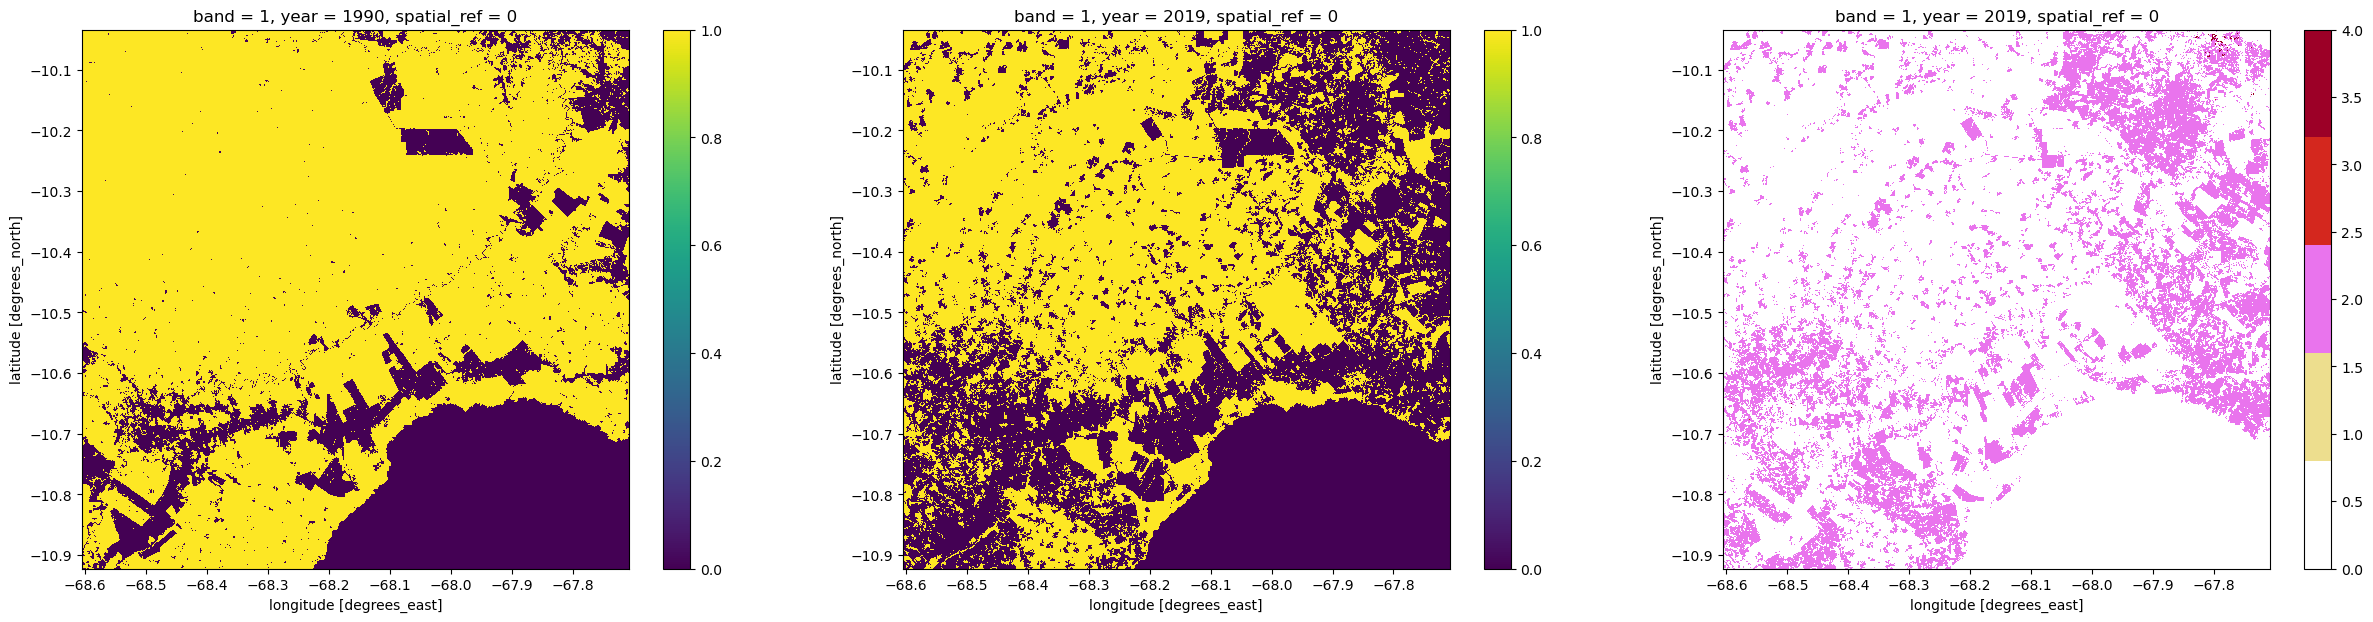

In [127]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(30, 7))

baseline_forest = baseline.rio.clip_box(*grid_data.iloc[[525]].to_crs(4326).total_bounds).isin(class_labels["forest"]).squeeze()
baseline_forest.plot.imshow(ax=ax[0])
compare_forest = compare.rio.clip_box(*grid_data.iloc[[525]].to_crs(4326).total_bounds).isin(class_labels["forest"]).squeeze()
compare_forest.plot.imshow(ax=ax[1])
(baseline_forest * compare_pasture + baseline_forest * compare_agriculture + baseline_forest * compare_urban + baseline_forest * compare_mining).squeeze().plot.imshow(ax=ax[2], cmap = cmap)

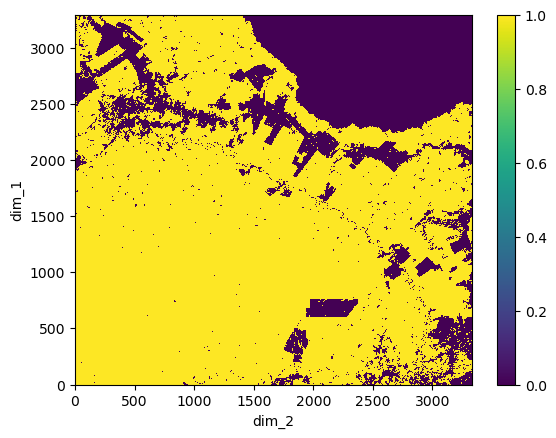

In [90]:
xr.DataArray(np.isin(baseline.rio.clip_box(*grid_data.iloc[[525]].to_crs(4326).total_bounds), )).squeeze().plot.imshow()

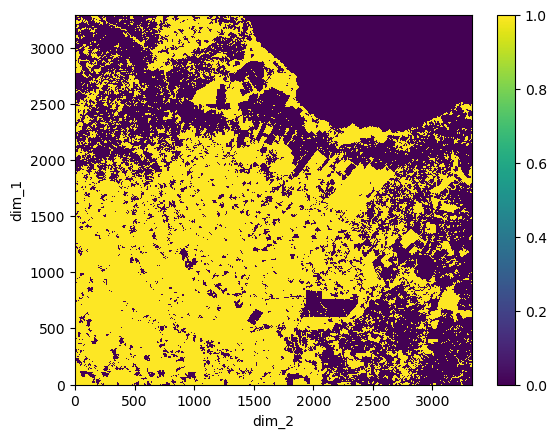

In [91]:
xr.DataArray(np.isin(compare.rio.clip_box(*grid_data.iloc[[525]].to_crs(4326).total_bounds), legend.loc[legend.Class.str.match(r"(^1\.)"), "ID"].values)).squeeze().plot.imshow()

In [61]:
for i in [525]:
    c_subset = drainage_polygons.loc[drainage_polygons.centroid.intersects(grid_data.iloc[[525]].to_crs(4326).iloc[0].geometry, align = False),:]
    
    c_height_profile = load_height_profile(expand_bounds(c_subset.total_bounds))

In [35]:
gpd.clip(drainage_polygons, )

/scratch/slurm_tmpdir/job_23545835/ipykernel_303374/3219030062.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gpd.clip(drainage_polygons, grid_data.iloc[[525]].to_crs(4326).centroid)


,estuary,river,geometry
8740,136.0,30901.0,POINT (-68.15655 -10.47820)


---

# Cloud Cover